# Ejercicio: Proyecto Molibdeno

## Enunciado

Ha recibido Vd. esta carta. Adopte el papel del destinatario y actúe en consecuencia justificando sus decisiones.

In [1]:
%%capture
#| echo: false
#| output: false

%load_ext jupyter_tikz
import pandas as pd
from pandas import Int64Dtype
from IPython.display import display, HTML, Image, IFrame, Math, Markdown, Latex

import os, sys
sys.path.append('../src')
from pmule import PredecessorTable, ProjectGraph, EarnedValue

import pandas as pd
import numpy as np
datos_enunciado = pd.read_csv("csv_files/datos_enunciado_molibdeno.csv", sep=';', index_col='actividad')

#%mkdir -p ~/temp
%cd ~/temp/

In [3]:
#| echo: false
#%pip install dataframe_image              > /dev/null
#%pip install pygraphviz "pandas[excel]"   > /dev/null
#%pip install numpyarray_to_latex          > /dev/null

#import dataframe_image as dfi
from jupyter_tikz import TexFragment, TexDocument


> Estimado Director de Proyectos:
>
> En relación con nuestra anterior conversación telefónica, le adjunto los detalles del proyecto “Molibdeno”, del que ha pasado a ser máximo responsable, y sobre el que  cuelga la amenaza de sufrir retrasos. Como ya habrá leído en nuestra última circular, a fin de salvar el bache económico actual, su correcta gestión económica es de vital importancia, pues la nefasta gestión del responsable de la negociación del contrato nos carga con unas penalizaciones por retraso de diez u.m./periodo, doble de lo habitual en este tipo de proyectos.
>
> Le anticipo una buena noticia. Con el cambio de Director de Proyecto, también cambiaremos de contratista principal para desarrollar las tareas del proyecto que restan por comenzar. La empresa anterior, “Borum”, dispone de una plantilla limitada, 150 técnicos, y eso le impide aceptar modificaciones en relación con las tareas ya comenzadas. El nuevo contratista, “Calcium”, dispone de 200 técnicos y nos asegura su disponibilidad y cooperación frente a cualquier modificación respecto a la planificación inicial.
>
> El Consejo de Administración desea tener en cuenta su valoración acerca de la actuación del anterior gestor, así como también agradecería que le proporcionara una enumeración justificada de las actuaciones que llevará a cabo a efectos de gestionar correctamente el proyecto.
>
> Reciba un cordial saludo.



Los datos del proyecto son los siguientes:

{{< pagebreak >}}

In [4]:
#| out-width: 100%
#| echo: false

#| tbl-cap: "Datos del proyecto
#| label: tbl-enunciado


tabla = datos_enunciado.copy().replace('----', '---')
tabla.columns = [ 'Precedente', 
              'Duración planificada', 
              'Duración real', 
              'Coste planificado', 
              'Coste real', 
              'Coste duración tope', 
              'Duración tope',
              'Porcentaje realizado',
              'Recursos',
              'Varianza',
              'Duración <br> pesimista']
tabla.style.set_properties(**{'text-align': 'center'}).format(precision=2)

,Precedente,Duración planificada,Duración real,Coste planificado,Coste real,Coste duración tope,Duración tope,Porcentaje realizado,Recursos,Varianza,Duración pesimista
actividad,,,,,,,,,,,
A,---,5,7,70,77,100,2,100,5,1,15
B,---,3,8,48,56,58,1,100,10,2,9
C,---,4,5,40,45,66,2,100,15,3,12
D,B,4,5,40,50,94,2,100,5,9,12
E,B,3,3,18,21,37,1,100,15,5,9
F,B,3,4,36,40,58,1,100,15,4,9
G,"A, D",4,6,96,90,111,1,100,10,6,12
H,F,4,6,48,42,120,2,100,5,7,12
I,"C, E",6,7,210,189,140,3,100,5,3,18


{{< pagebreak >}}

In [5]:
columnas = [columna for columna in datos_enunciado.columns if columna!= 'precedente']
datos_enunciado[columnas] = datos_enunciado[columnas].replace('----', np.nan).astype('Int64')

for col in datos_enunciado.select_dtypes(include=['float']).columns:
    datos_enunciado[col] = pd.to_numeric(datos_enunciado[col], errors='coerce').astype('Int64')

## Solución


In [6]:
datos_proyecto = datos_enunciado.copy()
prelaciones = PredecessorTable.from_dataframe_of_strings(datos_proyecto, activity='actividad', predecessor='precedente')
proyecto = prelaciones.create_project()

### Grafo PERT de la planificación inicial

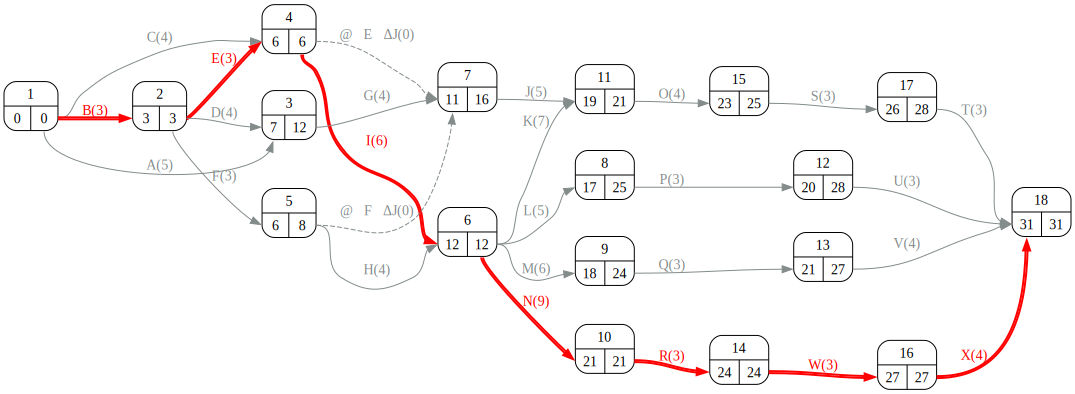

In [7]:
#| out-width: 100%
#| fig-cap: "Pert de la planificación inicial"
proyecto.pert(filename="pert_1.2.2.pdf", durations=datos_proyecto['duracion_planificada'], ranksep=0.7, rowsep=1.5)

In [9]:
Markdown(
        "El proyecto tenía una duración prevista de " 
        + str(proyecto.duration(datos_proyecto['duracion_planificada']))
        + " periodos. Como alternativa al grafo PERT podemos representar el diagrama de Gantt.")

El proyecto tenía una duración prevista de 31 periodos. Como alternativa al grafo PERT podemos representar el diagrama de Gantt.

### Diagrama de Gantt

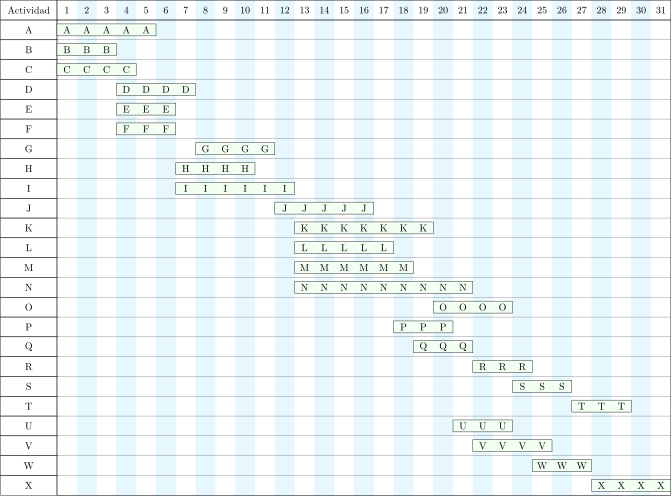

In [10]:
#| fig-cap: "Gantt de la planificación inicial"
gantt_df, dibujo = proyecto.gantt(datos_proyecto,
                      'duracion_planificada', 'names', tikz=True,
                      params=dict(
                        period_width=0.7,
                        row_height=0.7,
                        background_horizontal_line_color='black',
                        activity_relative_height=0.6,
                        critical_background_color='white!95!green',
                        regular_background_color='white!95!green',
                        regular_text_color='black',
                        critical_text_color='black',
                        activity_inner_text_style=r"\normalsize",),
                    )
TexFragment(dibujo).run_latex(save_pdf="gantt_1.2.3")

### Demanda de recursos
Hecho el diagrama de Gantt anterior resulta fácil comprobar si la demanda de recursos supone alguna dificultad en algun momento del proyecto.

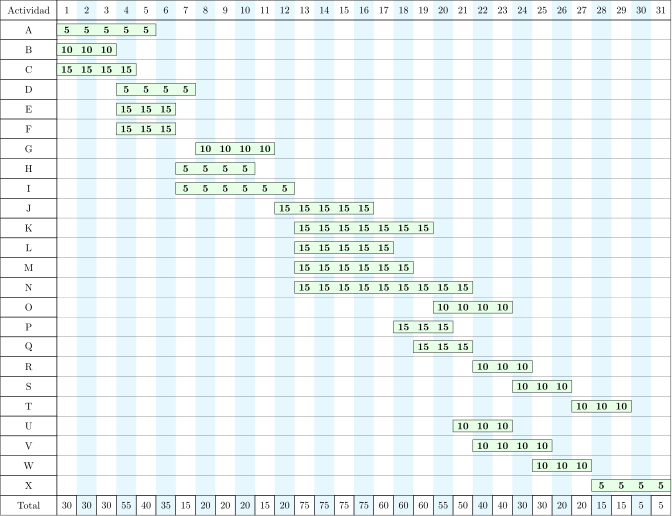

In [11]:
#| out-height: 80%
#| fig-cap: "Demanda de recursos en el tiempo"

gantt_recursos, dibujo = proyecto.gantt(datos_proyecto, 'duracion_planificada', 'recursos', total='fila',  tikz=True,
                    params=dict(
                        period_width=0.7,
                        row_height=0.7,
                        background_horizontal_line_color='black',
                        activity_relative_height=0.6,
                        critical_background_color='white!90!green',
                        regular_background_color='white!90!green',
                        regular_text_color='black',
                        critical_text_color='black',
                        activity_inner_text_style=r"\bfseries\normalsize",),
                    )

TexFragment(dibujo).run_latex(save_pdf="gantt_1.2.4")

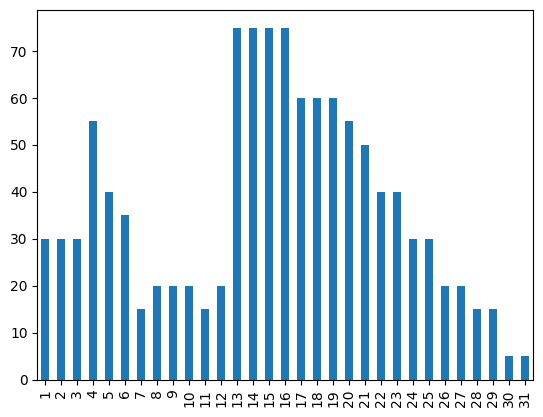

In [12]:
#| out-width: 50%
#| fig-cap: "Perfil de la demanda de recursos en el tiempo"

gantt_recursos.data.loc['Total'].plot(kind='bar').get_figure().savefig('graf_barras_recursos.pdf', format='pdf', bbox_inches='tight')

Estos resultados confirman que el uso de recursos no presenta ningún problema en este proyecto, ni con la plantilla del contratista anterior ni con la del nuevo, por ser muy inferior a la plantilla disponible de técnicos.

### Método del valor ganado

La evaluación del estado actual del proyecto puede realizarse a través del método del valor ganado. Para ello se utilizará el diagrama de Gantt mostrado anteriormente y el correspondiente a las duraciones reales.

In [13]:
datos_proyecto['duracion_real'] = datos_proyecto['duracion_real'].fillna(0)

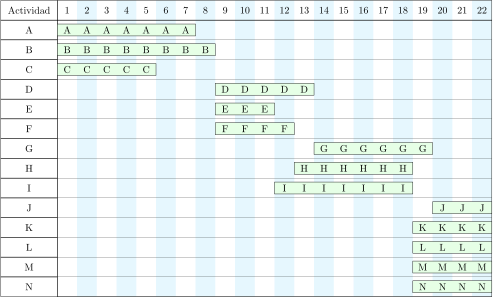

In [14]:
#| out-height: 80%
#| fig-cap: "Gantt de los trabajos realizados"

_, dibujo = proyecto.gantt(datos_proyecto, 'duracion_real', 'names', tikz=True,
            params=dict(
                        period_width=0.7,
                        row_height=0.7,
                        background_horizontal_line_color='black',
                        activity_relative_height=0.6,
                        critical_background_color='white!90!green',
                        regular_background_color='white!90!green',
                        regular_text_color='black',
                        critical_text_color='black',
                        activity_inner_text_style=r"\normalsize",),
)

TexFragment(dibujo).run_latex(save_pdf="gantt_2_inicial")

In [15]:
vg = EarnedValue(proyecto)

In [16]:
gantts = vg.calcula_gantts(datos_proyecto,
                           planned_durations_label='duracion_planificada',
                           actual_durations_label='duracion_real',
                           PV_label='coste_planificado',
                           AC_label='coste_real',
                           percentage_complete_label='realizado',
                           tikz=True,
                params=dict(
                        period_width=1.1,
                        row_height=0.7,
                        background_horizontal_line_color='black',
                        activity_relative_height=0.6,
                        critical_background_color='white!90!green',
                        regular_background_color='white!90!green',
                        regular_text_color='black',
                        critical_text_color='black',
                        activity_inner_text_style=r"\bfseries\normalsize",),
)

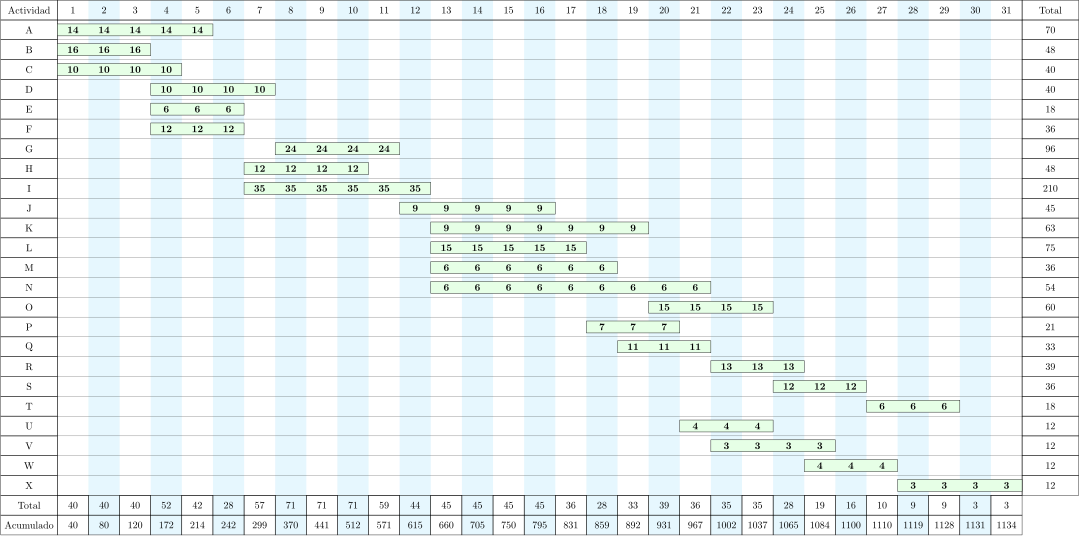

In [17]:
#| out-height: 80%
#| fig-cap: "PV: Valor planificado"

TexFragment(gantts['gantt_PV']).run_latex(save_pdf="gantt_2.0_PV")

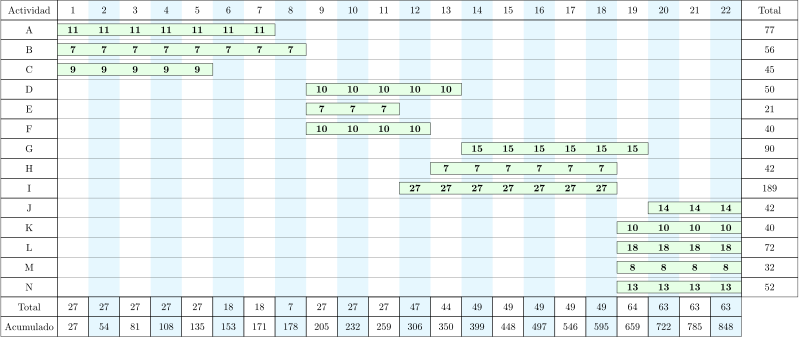

In [18]:
#| out-height: 80%
#| fig-cap: "AC: Coste real"

TexFragment(gantts['gantt_AC']).run_latex(save_pdf="gantt_2.0_AC")

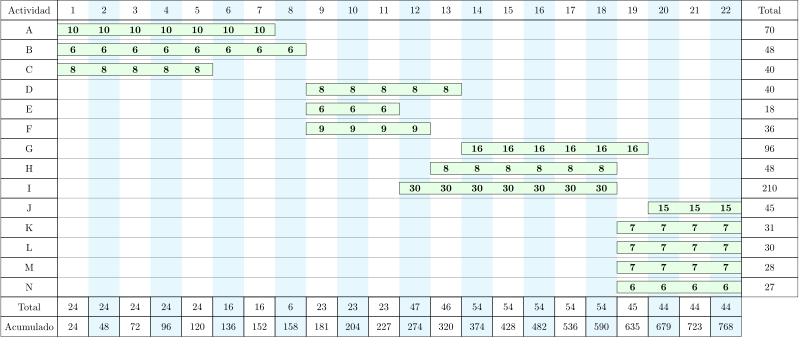

In [19]:
#| out-height: 80%
#| fig-cap: "EV: Valor ganado"

TexFragment(gantts['gantt_EV']).run_latex(save_pdf="gantt_2.0_EV")

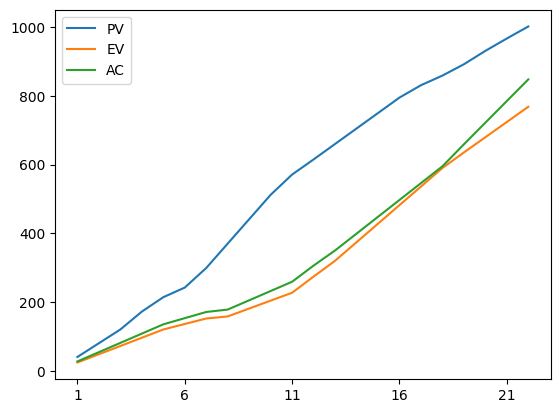

In [20]:
#| out-width: 50%
#| fig-cap: "Evolución en el tiempo de los parámetros del método del valor ganado"

acumulados = gantts['acumulados']
acumulados.plot(); #.get_figure().savefig('VG_acumulados.pdf', format='pdf', bbox_inches='tight');

En el punto de control, los valores de PV, AC, EV son:

In [21]:
acumulados.tail(1)

,PV,EV,AC
22,1002.0,768.3,848.0


El análisis del valor ganado indica que el proyecto va con retraso y sobrecoste.

### Cálculo de la duración prevista del proyecto

Para el cálculo de la duración prevista a la luz de la información recogida se asume que para:
   - las actividades ya terminadas se utilizará su duración real;
   - las actividades comenzadas pero no completadas lo harán a la velocidad seguida hasta ahora;
   - las actividades que no han comenzado, su duración prevista es la correspondiente a la planificación inicial.

In [22]:
datos_proyecto_actualizado = datos_proyecto.copy()

empezadas = datos_proyecto_actualizado['realizado'] > 0
datos_proyecto_actualizado.loc[empezadas, 'duracion_planificada']  = 100 * datos_proyecto.loc[empezadas, 'duracion_real'] / datos_proyecto.loc[empezadas, 'realizado']
datos_proyecto_actualizado.loc[~empezadas, 'duracion_planificada'] = datos_proyecto.loc[~empezadas, 'duracion_planificada']

Una vez obtenidas las duraciones previstas de las actividades, se puede calcular la nueva fecha de fin de proyecto.

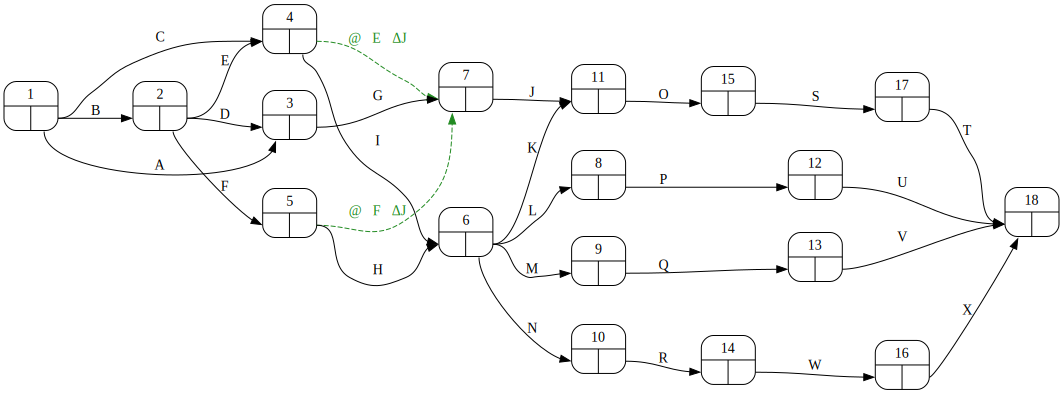

In [23]:
#| out-width: 100%
#| fig-cap: "Pert de la previsión a futuro del proyecto"

proyecto.pert(filename='pert_2.0.1_inicial.pdf', duraciones=datos_proyecto_actualizado['duracion_planificada'], ranksep=0.9)

El proyecto presenta ahora una nueva duración de 36 periodos.
De modo alternativo, se puede llegar a igual resultado representando el diagrama de Gantt.

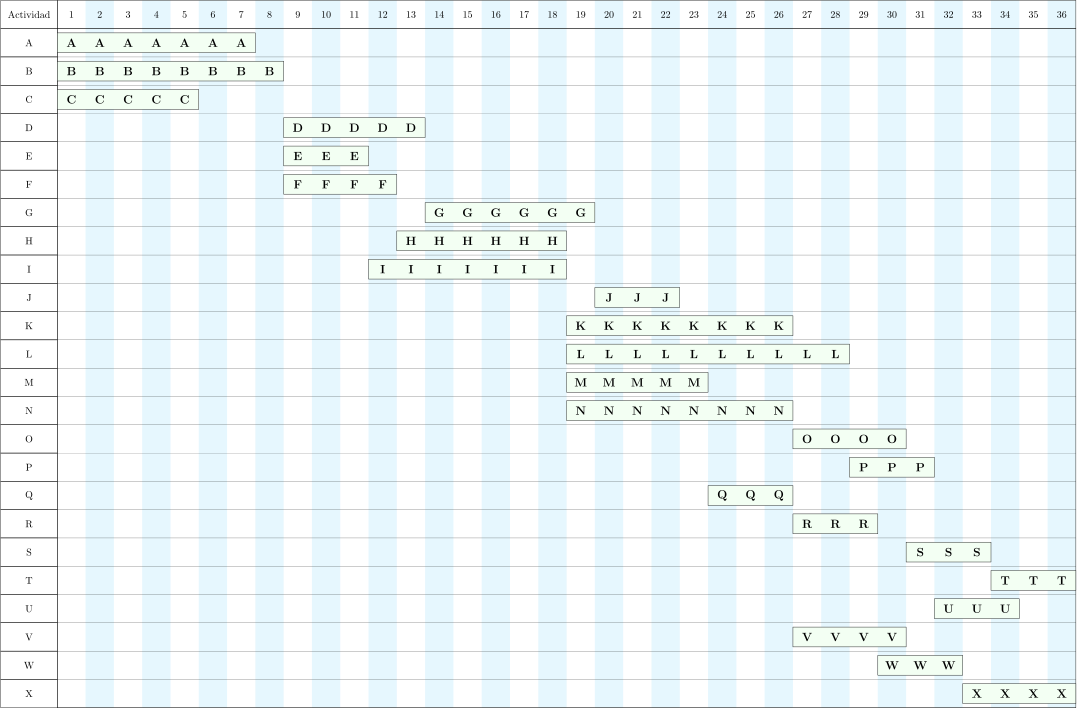

In [24]:
#| out-width: 100%
#| fig-cap: "Gantt de la previsión a futuro del proyecto"

_, dibujo = proyecto.gantt(datos_proyecto_actualizado, 'duracion_planificada', 'names',
                                            params=dict(
                                                                                    period_width=1,
                                                                                    row_height=1.0,
                                                                                    background_horizontal_line_color='black',
                                                                                    activity_relative_height=0.7,
                                                                                    critical_background_color='white!95!green',
                                                                                    regular_background_color='white!95!green',
                                                                                    regular_text_color='black',
                                                                                    critical_text_color='black',
                                                                                    number_of_periods=36
                                                                                     ), tikz=True)
TexFragment(dibujo).run_latex(save_pdf="gantt_2.0.1")

### Análisis de los costes incurridos por penalización vs. los costes derivados de la reducción de la duración del proyecto

Esta nueva situación tiene como consecuencia un retraso de 5 periodos con respecto a la planificación inicial. Dadas las penalizaciones por retraso del enunciado, las actuaciones del Director del Proyecto irán encaminadas a paliar el efecto negativo de este retraso. Para analizar de manera más simple la situación actual y presentar una estrategia de actuación se considera únicamente la parte de proyecto que resta por terminar.

In [25]:
datos_proyecto_simplificado = (datos_proyecto
                                  .query('realizado != 100')
                                  #.drop(['f1', 'f2'])
                                  .rename(columns={'duracion_planificada':'duracion', 'tiempo_tope':'duracion_tope'})
                                  .eval('cur=(coste_tiempo_tope - coste_planificado)/(duracion - duracion_tope)')
                                  .drop(['recursos', 'varianza_duracion', 'duracion_pesimista'], axis=1)
                                  .copy()
                              )

datos_proyecto_simplificado.loc[['K', 'L', 'M', 'N'], 'cur'] = np.inf
datos_proyecto_simplificado.loc[['K', 'L', 'M', 'N'], 'precedente'] = '----'
datos_proyecto_simplificado.loc[['O'], 'precedente'] = 'K'

empezadas = datos_proyecto_simplificado['realizado'] > 0
datos_proyecto_simplificado.loc[empezadas,:] = datos_proyecto_simplificado.eval('duracion = (100 - realizado) * duracion_real / realizado')

datos_proyecto_simplificado.drop(['duracion_real', 'coste_planificado', 'coste_real', 'coste_tiempo_tope', 'realizado'], axis=1, inplace=True)
datos_proyecto_simplificado

,precedente,duracion,duracion_tope,cur
actividad,,,,
K,----,4,1,inf
L,----,6,1,inf
M,----,1,1,inf
N,----,4,1,inf
O,K,4,2,8.0
P,L,3,1,7.0
Q,M,3,1,8.0
R,N,3,1,5.0
S,O,3,1,6.0


In [26]:
prelaciones_simplificado = PredecessorTable.from_dataframe_of_strings(datos_proyecto_simplificado, activity='actividad', predecessor='precedente')
proyecto_simplificado    = prelaciones_simplificado.create_project()

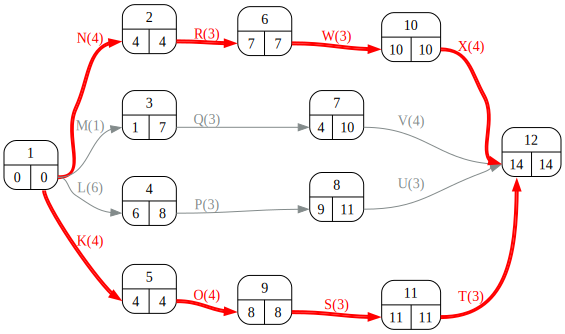

In [27]:
#| out-width: 100%
#| fig-cap: "Pert del resto del proyecto por completar"

proyecto_simplificado.pert(filename="pert_2.0.2_simplificado.pdf", durations=datos_proyecto_simplificado['duracion'])

::: {.landscape}

A fin de paliar el efecto del retraso y no pagar un exceso en penalizaciones, se considera la reducción de la duración del proyecto con mínimo coste.

In [28]:
#| tab-width: 80%
#| tab-cap: "Algoritmo de Ackoff-Sassieni"

ackoff, best_option, duration, available = proyecto_simplificado.ackoff(durations     = datos_proyecto_simplificado['duracion'],
                            min_durations = datos_proyecto_simplificado['duracion_tope'],
                            costs         = datos_proyecto_simplificado['cur'],
                            reduction=5
                            )
ackoff

Step: 0,	 Critical paths: ['Route_1', 'Route_4']
		 Best option: ['S', 'W'], 	 Cost: 9.0
Step: 1,	 Critical paths: ['Route_1', 'Route_4']
		 Best option: ['S', 'W'], 	 Cost: 9.0
Step: 2,	 Critical paths: ['Route_1', 'Route_2', 'Route_4']
		 Best option: ['T', 'R', 'U'], 	 Cost: 15.0
Step: 3,	 Critical paths: ['Route_1', 'Route_2', 'Route_4']
		 Best option: ['T', 'R', 'U'], 	 Cost: 15.0
Step: 4,	 Critical paths: ['Route_1', 'Route_2', 'Route_4']
		 Best option: ['O', 'P', 'X'], 	 Cost: 24.0

--------------------------------------------------------------------------------


,K,L,M,N,O,P,Q,R,S,T,U,V,W,X,0,1,2,3,4,5
Route_1,inf,,,,8.0,,,,6.0,7.0,,,,,14.0,13.0,12.0,11.0,10.0,9.0
Route_2,,inf,,,,7.0,,,,,3.0,,,,12.0,12.0,12.0,11.0,10.0,9.0
Route_3,,,inf,,,,8.0,,,,,4.0,,,8.0,8.0,8.0,8.0,8.0,8.0
Route_4,,,,inf,,,,5.0,,,,,3.0,9.0,14.0,13.0,12.0,11.0,10.0,9.0
0,3.0,5.0,0.0,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,,,,,,
1,3.0,5.0,0.0,3.0,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,1.0,2.0,,,,,,
2,3.0,5.0,0.0,3.0,2.0,2.0,2.0,2.0,0.0,2.0,2.0,2.0,0.0,2.0,,,,,,
3,3.0,5.0,0.0,3.0,2.0,2.0,2.0,1.0,0.0,1.0,1.0,2.0,0.0,2.0,,,,,,
4,3.0,5.0,0.0,3.0,2.0,2.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,2.0,,,,,,
5,3.0,5.0,0.0,3.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,,,,,,


:::


La comparativa de costes entre la opción de recortar el proyecto y la opción de pagar las penalizaciones es la siguiente.

In [29]:
#| out-width: 100%
#| tab-cap: "Comparativa de costes"
precio_reduccion = pd.Series({key:datos_proyecto_simplificado.loc[actividades,'cur'].sum() for key,actividades in best_option.items()}).to_frame('Coste de Reducción')
precio_reduccion['Coste de Reducción Acumulado'] = precio_reduccion['Coste de Reducción'].cumsum()
precio_reduccion['Penalizacion'] = [40, 30, 20, 10, 0]
precio_reduccion['duracion']= [35, 34, 33, 32,31]
precio_reduccion = precio_reduccion._append({'Coste de Reducción':0, 'Coste de Reducción Acumulado':0, 'duracion': 36, 'Penalizacion': 50}, ignore_index=True).sort_values('duracion', ascending=False)
precio_reduccion.set_index('duracion', inplace=True)
precio_reduccion['Costes Totales'] = precio_reduccion['Coste de Reducción Acumulado'] + precio_reduccion['Penalizacion']
precio_reduccion

,Coste de Reducción,Coste de Reducción Acumulado,Penalizacion,Costes Totales
duracion,,,,
36,0.0,0.0,50,50.0
35,9.0,9.0,40,49.0
34,9.0,18.0,30,48.0
33,15.0,33.0,20,53.0
32,15.0,48.0,10,58.0
31,24.0,72.0,0,72.0


In [30]:
# Duración con mínimos costes totales
mejor_opcion = int(precio_reduccion.index[precio_reduccion['Costes Totales'].argmin()])


In [31]:
Markdown("La suma de costes agregados resultante de sumar los costes de reducción acumulados más los costes de penalización acumulados indican que la operación más ventajosa desde el punto de vista de estos costes es reducir el proyecto hasta dejar su duración en " + str(mejor_opcion) + " periodos.")

La suma de costes agregados resultante de sumar los costes de reducción acumulados más los costes de penalización acumulados indican que la operación más ventajosa desde el punto de vista de estos costes es reducir el proyecto hasta dejar su duración en 34 periodos.